# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpviqcbebt
  JVM stdout: /tmp/tmpviqcbebt/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpviqcbebt/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_patrickh_alvbzb
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#  Download, explore, and prepare UCI credit card default data

***

The objective of this notebook is to test and compare local explanations created by the popular methods: LIME, Treeinterpreter, and Shapley on an XGBoost model trained on a well-known, somewhat realistic data set.

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

#### Import data and clean

In [5]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

#### Assign modeling roles

In [6]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics

In [7]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


#### Calculate Pearson correlation

In [8]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

In [9]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

# Train XGBoost with monotonicity constraints

#### Split data into training and test sets for early stopping

In [10]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier

In [11]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress

[0]	train-auc:0.738066	eval-auc:0.733449
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.772991	eval-auc:0.769311
[2]	train-auc:0.775536	eval-auc:0.772624
[3]	train-auc:0.776248	eval-auc:0.771985
[4]	train-auc:0.777216	eval-auc:0.772796
[5]	train-auc:0.777782	eval-auc:0.773066
[6]	train-auc:0.777783	eval-auc:0.773471
[7]	train-auc:0.777856	eval-auc:0.773591
[8]	train-auc:0.777633	eval-auc:0.773209
[9]	train-auc:0.777417	eval-auc:0.772892
[10]	train-auc:0.777519	eval-auc:0.772666
[11]	train-auc:0.778476	eval-auc:0.773346
[12]	train-auc:0.778541	eval-auc:0.773312
[13]	train-auc:0.778351	eval-auc:0.773266
[14]	train-auc:0.778519	eval-auc:0.773695
[15]	train-auc:0.779383	eval-auc:0.774314
[16]	train-auc:0.779555	eval-auc:0.77473
[17]	train-auc:0.780178	eval-auc:0.775043
[18]	train-auc:0.780743	eval-auc:0.775246
[19]	train-auc:0.78146	eval-auc:0.776021
[20]	train-auc:0.781944	eval-au

# Global Variable Importance 

***

#### XGBoost variable importance

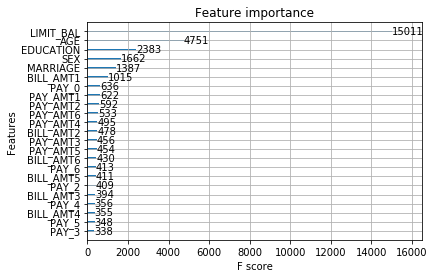

In [12]:
_ = plot_importance(xgb_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(xgb_model)

Weight,Feature
0.4267,PAY_0
0.1550,PAY_2
0.0569,PAY_3
0.0559,PAY_5
0.0405,PAY_AMT3
0.0389,PAY_4
0.0372,PAY_AMT2
0.0352,PAY_6
0.0198,PAY_AMT1
0.0174,LIMIT_BAL


#### Shapley variable importance

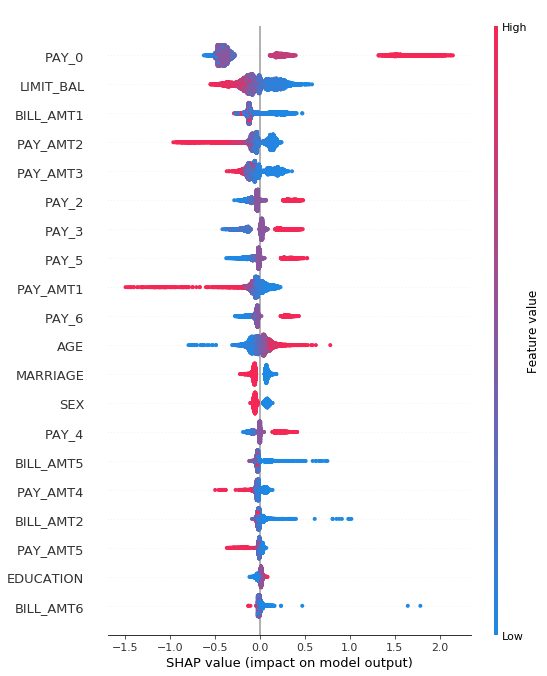

In [14]:
shap_values = xgb_model.predict(dtest, pred_contribs=True)
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

#### Function for calculating partial dependence

In [15]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [16]:
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model)

In [17]:
par_dep_PAY_0

,PAY_0,partial_dependence
0,-2.0,0.164452
1,-1.5,0.174660
2,-1.0,0.174660
3,-0.5,0.175176
4,0.0,0.175179
5,0.5,0.260061
6,1.0,0.260061
7,1.5,0.555753
8,2.0,0.555753
9,2.5,0.555879


#### Bind XGBoost predictions to training data

In [18]:
xgb_preds = pd.DataFrame(xgb_model.predict(dtest))

In [19]:
test.reset_index(inplace=True)
test.drop(['index'], inplace=True, axis=1)

In [20]:
decile_frame = pd.concat([test, xgb_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})
decile_hframe = h2o.H2OFrame(decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
decile_frame.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,predict
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,0.774720
1,7,500000,1,1,2,29,0,0,0,0,...,483003,473944,55000,40000,38000,20239,13750,13770,0,0.018403
2,9,140000,2,3,1,28,0,0,2,0,...,11793,3719,3329,0,432,1000,1000,1000,0,0.214771
3,11,200000,2,3,2,34,0,0,2,0,...,1828,3731,2306,12,50,300,3738,66,0,0.238153
4,12,260000,2,1,2,51,-1,-1,-1,-1,...,22287,13668,21818,9966,8583,22301,0,3640,0,0.067799


#### Find percentiles of XGBoost predictions

In [22]:
ds_ = DataMakerAndGetter()
percentile_dict = ds_.get_percentile_dict('predict', 'ID', decile_hframe)

In [23]:
percentile_dict

{0: 23477,
 10: 16339,
 20: 11924,
 30: 7711,
 40: 2941,
 50: 367,
 60: 21027,
 70: 14844,
 80: 15491,
 90: 27719,
 99: 17757}

#### Calculate ICE curve values

In [24]:
# retreive bins from original partial dependence calculation
bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                      test[test['ID'] == int(percentile_dict[i])][X], 
                                      xgb_model, 
                                      bins=bins_PAY_0)['partial_dependence']
    

#### Display partial dependence and ICE for PAY_0

In [25]:
par_dep_PAY_0

,PAY_0,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2.0,0.164452,0.000981,0.050637,0.074242,0.094250,0.111219,0.140956,0.166176,0.236824,0.297155,0.146062,0.831526
1,-1.5,0.174660,0.001083,0.055663,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325452,0.159660,0.849480
2,-1.0,0.174660,0.001083,0.055663,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325452,0.159660,0.849480
3,-0.5,0.175176,0.001287,0.057499,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325901,0.159660,0.854391
4,0.0,0.175179,0.001287,0.057499,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325901,0.159660,0.854391
5,0.5,0.260061,0.003860,0.128749,0.172442,0.190945,0.194201,0.242888,0.278614,0.299842,0.458100,0.269978,0.907970
6,1.0,0.260061,0.003860,0.128749,0.172442,0.190945,0.194201,0.242888,0.278614,0.299842,0.458100,0.269978,0.907970
7,1.5,0.555753,0.028605,0.530701,0.541829,0.569588,0.496096,0.643140,0.690764,0.525924,0.730770,0.599291,0.971720
8,2.0,0.555753,0.028605,0.530701,0.541829,0.569588,0.496096,0.643140,0.690764,0.525924,0.730770,0.599291,0.971720
9,2.5,0.555879,0.028613,0.530815,0.542152,0.569588,0.496260,0.643140,0.690764,0.525924,0.730770,0.599532,0.972647


#### Plot partial dependence and ICE

In [26]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


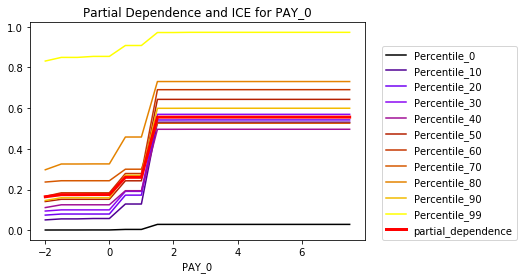

In [27]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0)

#### Train single h2o decision tree

In [28]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     nfolds=3,          # cross-validation 
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip


In [29]:
surrogate.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0550253,0.0003933,0.0542437,0.0554924,0.0553397
mean_residual_deviance,0.0058633,0.0000444,0.0057911,0.0058548,0.0059441
mse,0.0058633,0.0000444,0.0057911,0.0058548,0.0059441
r2,0.8619572,0.0010759,0.8598133,0.8631891,0.8628691
residual_deviance,0.0058633,0.0000444,0.0057911,0.0058548,0.0059441
rmse,0.0765713,0.0002897,0.0760993,0.0765164,0.0770982
rmsle,0.0611636,0.0002877,0.0606098,0.0613054,0.0615757


#### Create GraphViz dot file

In [30]:
# title for plot
title = 'Credit Card Data Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Credit Card Data Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [31]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


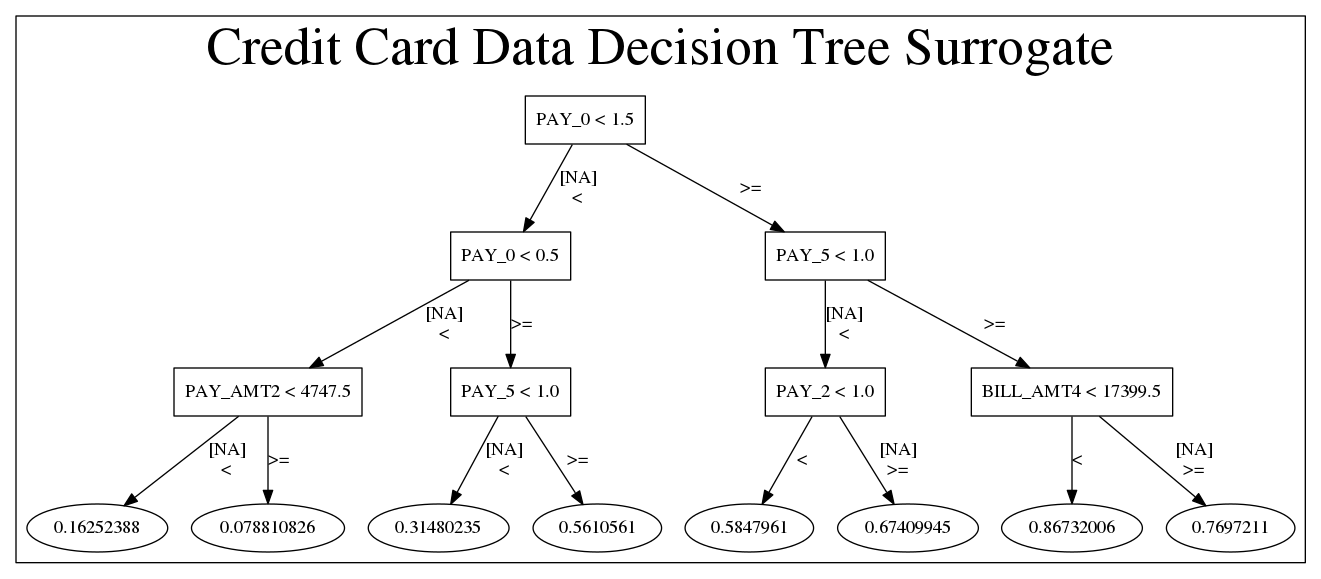

In [32]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [33]:
def eli5_dd(decile):
    row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(xgb_model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(xgb_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [34]:
# learn what to discretize from var imp 
# explainer = LIMEExplainer(training_frame=test, X=X, model=xgb_model, discretize=['PAY_0', 'PAY_2', 'PAY_3'])
explainer = LIMEExplainer(training_frame=test, X=X, model=xgb_model)

def lime(decile):
    row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displays the Shapley results at the choosen decile

In [35]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [36]:
decile = 10
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

           Approximate Local Contributions
PAY_0                            -0.468699
LIMIT_BAL                        -0.330274
PAY_AMT1                         -0.233416
PAY_AMT2                         -0.212458
PAY_AMT3                         -0.142837
BILL_AMT1                        -0.130155
SEX                              -0.058942
BILL_AMT2                        -0.036197
PAY_AMT6                         -0.035014
PAY_AMT4                         -0.033662
BILL_AMT5                        -0.033618
PAY_6                            -0.017624
PAY_AMT5                         -0.015722
BILL_AMT4                        -0.014277
PAY_2                            -0.011703
BILL_AMT3                        -0.010269
BILL_AMT6                        -0.008971
PAY_5                            -0.006559
PAY_4                            -0.001232
EDUCATION                         0.016901
PAY_3                             0.059656
MARRIAGE                          0.083817
AGE        

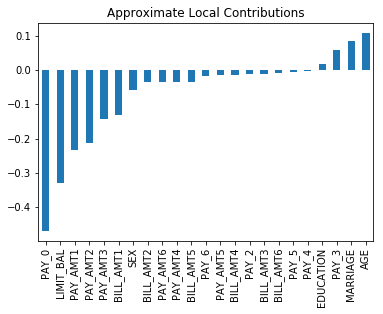

In [37]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7fc45048f390>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='AGE', weight=0.14126849841960812, std=None, value=41.0), FeatureWeight(feature='MARRIAGE', weight=0.06539793366754618, std=None, value=1.0), FeatureWeight(feature='PAY_3', weight=0.026206034447656873, std=None, value=0.0), FeatureWeight(feature='EDUCATION', weight=0.019615447374296886, std=None, value=2.0), FeatureWeight(feature='PAY_6', weight=0.0009519221428973654, std=None, value=0.0)], neg=[FeatureWeight(feature='LIMIT_BAL', weight=-0.48051545533996964, std=None, value=420000.0), FeatureWeight(feature='PAY_0', weight=-0.41896827829939426, std=None, value=0.0), FeatureWeight(feature='PAY_AMT1', weight=-0.20606679066954842, std=None, value=33808.0), FeatureWeight(feature='PAY_AMT2', weight=-0.16214814545459302, std=None, value=14996.0), FeatureWeight(feature='PAY_AMT3', weight=-0.14274467107635624, std=None, value=13209.0), FeatureWeight(feature='BILL_AMT1', weight=-0.10265594720385038, std=None, value=373978.0), FeatureWeight(feature='BILL_AMT2', weight=-0.06254677698049986, std=None, value=389754.0), FeatureWeight(feature='SEX', weight=-0.06190215347382486, std=None, value=2.0), FeatureWeight(feature='PAY_2', weight=-0.02651960647802904, std=None, value=0.0), FeatureWeight(feature='BILL_AMT5', weight=-0.02582535260384361, std=None, value=354813.0), FeatureWeight(feature='PAY_AMT6', weight=-0.020497349434992443, std=None, value=16298.0), FeatureWeight(feature='PAY_AMT4', weight=-0.016744690616057524, std=None, value=12890.0), FeatureWeight(feature='PAY_5', weight=-0.014575998477968078, std=None, value=0.0), FeatureWeight(feature='BILL_AMT4', weight=-0.011677110037661899, std=None, value=361024.0), FeatureWeight(feature='PAY_AMT5', weight=-0.010914854880041326, std=None, value=11081.0), FeatureWeight(feature='PAY_4', weight=-0.01063990868641441, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=-0.009734693712719808, std=None, value=1.0), FeatureWeight(feature='BILL_AMT3', weight=-0.009076024260820633, std=None, value=366938.0), FeatureWeight(feature='BILL_AMT6', weight=-0.0024111205654204315, std=None, value=344221.0)], pos_remaining=0, neg_remaining=0), proba=None, score=-1.5427250922000013, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

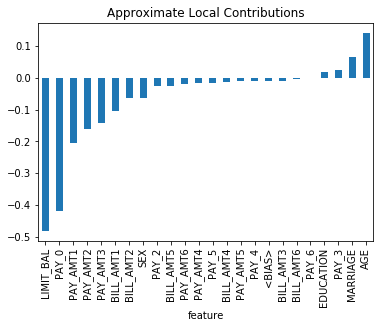

In [38]:
eli5_dd(decile)

In [39]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -2.796777692533134


### LIME


Model Prediction: 0.06
Local GLM Prediction: 0.13
Local GLM R-square: 0.43
Local GLM Intercept: -0.10

Approximate Local Contributions:
        Input  Local Contribution
0    PAY_AMT6            0.000302
1    PAY_AMT5            0.000478
2    PAY_AMT4            0.000616
3    PAY_AMT3            0.000818
4    PAY_AMT2            0.001051
5    PAY_AMT1            0.003942
6    MARRIAGE            0.008503
7   EDUCATION            0.013278
8   BILL_AMT6            0.013957
9   BILL_AMT5            0.015842
10  BILL_AMT4            0.016470
11  BILL_AMT3            0.016734
12  BILL_AMT1            0.018092
13        AGE            0.018966
14  BILL_AMT2            0.019200
15        SEX            0.030992
16  LIMIT_BAL            0.054181
None


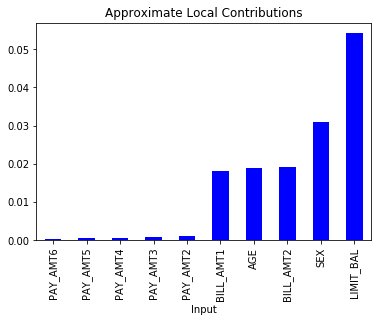

In [40]:
lime(decile)

##  Median of predictions

In [41]:
decile = 50
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

           Approximate Local Contributions
PAY_0                            -0.411915
BILL_AMT1                        -0.125210
SEX                              -0.061932
PAY_AMT2                         -0.042522
PAY_6                            -0.041212
PAY_AMT1                         -0.035968
PAY_2                            -0.034426
BILL_AMT5                        -0.028345
PAY_5                            -0.024211
PAY_AMT6                         -0.016077
PAY_AMT4                         -0.014974
BILL_AMT2                        -0.013526
PAY_4                            -0.011672
BILL_AMT3                        -0.009626
PAY_AMT5                         -0.009130
BILL_AMT6                        -0.008353
BILL_AMT4                        -0.004733
PAY_AMT3                         -0.002004
PAY_3                             0.010511
EDUCATION                         0.013597
MARRIAGE                          0.064320
AGE                               0.129554
LIMIT_BAL  

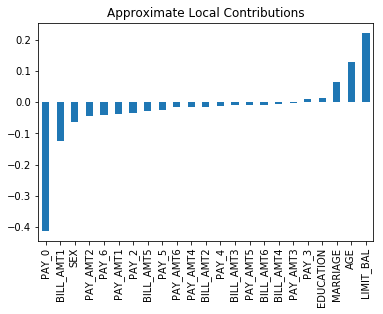

In [42]:
shapley(row)

### TreeInterpreter 

Explanation(estimator='<xgboost.core.Booster object at 0x7fc45048f390>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='LIMIT_BAL', weight=0.3169238969675609, std=None, value=50000.0), FeatureWeight(feature='MARRIAGE', weight=0.06969734026488657, std=None, value=1.0), FeatureWeight(feature='AGE', weight=0.058888429496241165, std=None, value=61.0), FeatureWeight(feature='EDUCATION', weight=0.02176956749995677, std=None, value=2.0), FeatureWeight(feature='PAY_3', weight=0.005653859226067826, std=None, value=0.0), FeatureWeight(feature='PAY_AMT3', weight=0.0009899483890423225, std=None, value=975.0)], neg=[FeatureWeight(feature='PAY_0', weight=-0.42410143888051804, std=None, value=0.0), FeatureWeight(feature='BILL_AMT1', weight=-0.11940511720034033, std=None, value=47166.0), FeatureWeight(feature='PAY_AMT2', weight=-0.07445132815270457, std=None, value=2237.0), FeatureWeight(feature='SEX', weight=-0.0607602903684865, std=None, value=2.0), FeatureWeight(feature='PAY_AMT1', weight=-0.04857168933700309, std=None, value=3000.0), FeatureWeight(feature='PAY_2', weight=-0.046187118395056716, std=None, value=0.0), FeatureWeight(feature='PAY_6', weight=-0.030875118159245138, std=None, value=0.0), FeatureWeight(feature='PAY_AMT6', weight=-0.028560399966908755, std=None, value=1039.0), FeatureWeight(feature='BILL_AMT5', weight=-0.022016795090588792, std=None, value=23171.0), FeatureWeight(feature='PAY_4', weight=-0.016004675246565722, std=None, value=0.0), FeatureWeight(feature='PAY_AMT5', weight=-0.014491867534213564, std=None, value=2000.0), FeatureWeight(feature='PAY_5', weight=-0.013912554260662426, std=None, value=0.0), FeatureWeight(feature='PAY_AMT4', weight=-0.012168227600849787, std=None, value=1000.0), FeatureWeight(feature='<BIAS>', weight=-0.009734693712719808, std=None, value=1.0), FeatureWeight(feature='BILL_AMT6', weight=-0.005891945467181839, std=None, value=24774.0), FeatureWeight(feature='BILL_AMT2', weight=-0.005074694449399835, std=None, value=49396.0), FeatureWeight(feature='BILL_AMT3', weight=-0.004137887068251654, std=None, value=50476.0), FeatureWeight(feature='BILL_AMT4', weight=-0.00277721959805933, std=None, value=23319.0)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.465200018645, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

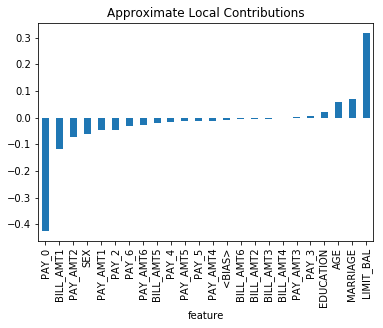

In [43]:
eli5_dd(decile)

In [44]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -1.7192525431094163


### LIME


Model Prediction: 0.15
Local GLM Prediction: 0.49
Local GLM R-square: 0.32
Local GLM Intercept: 0.68

Approximate Local Contributions:
        Input  Local Contribution
0         AGE           -0.058120
1         SEX           -0.049531
2   EDUCATION           -0.025672
3    MARRIAGE           -0.017592
4   LIMIT_BAL           -0.007654
5   BILL_AMT3           -0.004699
6   BILL_AMT2           -0.004647
7   BILL_AMT1           -0.004422
8   BILL_AMT6           -0.002385
9   BILL_AMT5           -0.002259
10  BILL_AMT4           -0.002236
11   PAY_AMT1           -0.000958
12   PAY_AMT5           -0.000733
13   PAY_AMT2           -0.000556
14   PAY_AMT4           -0.000304
15   PAY_AMT6           -0.000289
16   PAY_AMT3           -0.000260
None


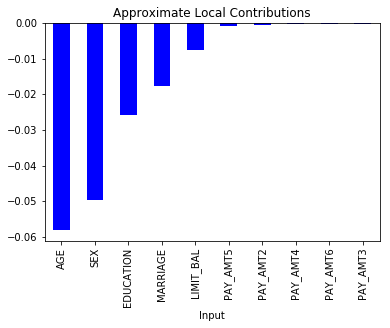

In [45]:
lime(decile)

##  90th decile of model predictions

In [46]:
decile = 90
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

In [47]:
row

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,predict
8376,27719,90000,2,2,2,24,2,0,0,2,...,89221,91596,4100,8245,0,3450,7200,0,1,0.599292


### Shapley values

           Approximate Local Contributions
BILL_AMT1                        -0.110589
AGE                              -0.096471
MARRIAGE                         -0.080873
PAY_AMT2                         -0.064753
PAY_6                            -0.052491
BILL_AMT5                        -0.042470
SEX                              -0.026670
PAY_AMT4                         -0.022627
PAY_AMT1                         -0.014891
BILL_AMT2                        -0.014388
PAY_5                            -0.010738
BILL_AMT3                        -0.010732
BILL_AMT6                        -0.010083
BILL_AMT4                        -0.009537
PAY_AMT5                         -0.004466
PAY_2                             0.003455
EDUCATION                         0.008958
PAY_AMT6                          0.037310
PAY_3                             0.055879
LIMIT_BAL                         0.057011
PAY_AMT3                          0.111882
PAY_4                             0.207193
PAY_0      

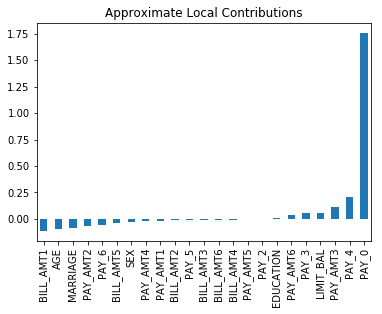

In [48]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7fc45048f390>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='PAY_0', weight=1.840726509829763, std=None, value=2.0), FeatureWeight(feature='PAY_4', weight=0.18719219868262635, std=None, value=2.0), FeatureWeight(feature='PAY_AMT3', weight=0.05341854983227486, std=None, value=0.0), FeatureWeight(feature='PAY_3', weight=0.0515922103597632, std=None, value=0.0), FeatureWeight(feature='PAY_AMT6', weight=0.049103624004179704, std=None, value=0.0), FeatureWeight(feature='LIMIT_BAL', weight=0.023397968099060903, std=None, value=90000.0), FeatureWeight(feature='PAY_AMT1', weight=0.022450945999154176, std=None, value=4100.0), FeatureWeight(feature='PAY_AMT5', weight=0.007475938752441164, std=None, value=7200.0), FeatureWeight(feature='PAY_2', weight=0.005543738780018485, std=None, value=0.0), FeatureWeight(feature='EDUCATION', weight=0.00015983964801691652, std=None, value=2.0)], neg=[FeatureWeight(feature='MARRIAGE', weight=-0.11587752486068419, std=None, value=2.0), FeatureWeight(feature='BILL_AMT1', weight=-0.09333710452252324, std=None, value=89346.0), FeatureWeight(feature='PAY_6', weight=-0.09039780397121719, std=None, value=0.0), FeatureWeight(feature='BILL_AMT5', weight=-0.07901963408884112, std=None, value=89221.0), FeatureWeight(feature='PAY_5', weight=-0.048724529562618954, std=None, value=0.0), FeatureWeight(feature='AGE', weight=-0.04720519476108612, std=None, value=24.0), FeatureWeight(feature='PAY_AMT2', weight=-0.030666494395657003, std=None, value=8245.0), FeatureWeight(feature='PAY_AMT4', weight=-0.022871399868175546, std=None, value=3450.0), FeatureWeight(feature='SEX', weight=-0.014222511799670436, std=None, value=2.0), FeatureWeight(feature='BILL_AMT3', weight=-0.010712855037480866, std=None, value=93755.0), FeatureWeight(feature='BILL_AMT6', weight=-0.009735289775551626, std=None, value=91596.0), FeatureWeight(feature='<BIAS>', weight=-0.009734693712719808, std=None, value=1.0), FeatureWeight(feature='BILL_AMT2', weight=-0.009728250070278766, std=None, value=89466.0), FeatureWeight(feature='BILL_AMT4', weight=-0.002261120060793781, std=None, value=89706.0)], pos_remaining=0, neg_remaining=0), proba=None, score=1.6565671174999996, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

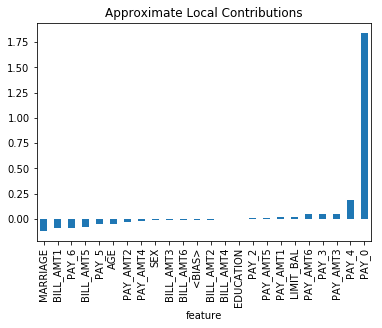

In [49]:
eli5_dd(decile)

In [50]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.40251465275609066


### LIME


Model Prediction: 0.60
Local GLM Prediction: 0.49
Local GLM R-square: 0.03
Local GLM Intercept: 0.53

Approximate Local Contributions:
       Input  Local Contribution
0        SEX       -2.212020e-02
1  LIMIT_BAL       -1.097012e-02
2  EDUCATION       -4.320404e-03
3   MARRIAGE       -9.689761e-04
4        AGE       -1.354126e-04
5      PAY_0       -2.351183e-11
6      PAY_4       -2.358121e-16
7  BILL_AMT1       -1.234234e-17
8  BILL_AMT6       -5.150921e-18
9   PAY_AMT2       -2.492660e-18
None


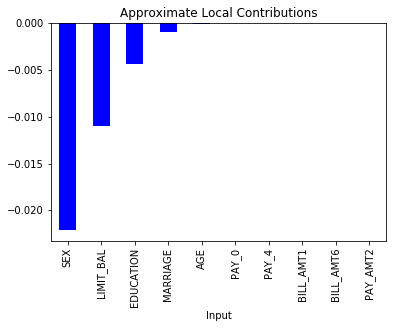

In [51]:
lime(decile)

In [52]:
h2o.cluster().shutdown()

H2O session _sid_8208 closed.
